## Monte Carlo Simulation

    Introduction to Generated Stochastic Process
A Monte Carlo simulation is a technique that uses random sampling to model and understand complex systems or processes that involve uncertainty. By running thousands or millions of simulated scenarios with randomly generated inputs, it estimates probabilities, risks, or expected outcomes when exact calculation is difficult or impossible. For example, in finance, it can simulate many possible future stock prices to predict portfolio returns and assess the risk of loss. Overall, Monte Carlo provides a probabilistic picture of possible outcomes, helping in decision-making and risk analysis.

In [134]:
import numpy as np
import random
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')
plt.style.use('dark_background')

### Importing data from yfinance
---

Here, we first define a list of stock tickers that represent the assets included in the portfolio: Amazon (AMZN), Microsoft (MSFT), Apple (AAPL), Google (GOOGL), and NVIDIA (NVDA). We then specify the time period of interest, from January 1, 2010 to September 10, 2024. Using the yfinance library, we download the historical closing prices for each of these stocks over the selected timeframe. The resulting dataset provides the price history needed to compute returns, analyze risk, and run portfolio simulations such as Monte Carlo analysis.

In [248]:
#Choice your trading portfolio investment containing stock tickers:
tickers = ["AMZN","MSFT","AAPL","GOOGL","NVDA"]
#Timeframe:
start_date = "2010-01-01"
end_date = "2024-09-10"
#Data close price:
stock_data = yf.download(tickers=tickers, start=start_date, end=end_date)["Close"]

[*********************100%***********************]  5 of 5 completed


### Data visualization

---
This code first computes the **covariance matrix** of the stock returns, which captures how each asset moves relative to the others and preserves their historical correlations. The `sns.heatmap` then visualizes this covariance matrix, allowing us to see which assets tend to move together and the magnitude of their variances and covariances. On the right subplot, the code plots the **historical closing prices** of Apple, Amazon, Google, Microsoft, and Nvidia over time, giving a visual sense of how each stock has performed individually. The legend identifies each stock, making it easy to compare trends and relative movements. Together, the heatmap and line plots provide both a **numerical and visual understanding of risk and historical price behavior** before running portfolio simulations.


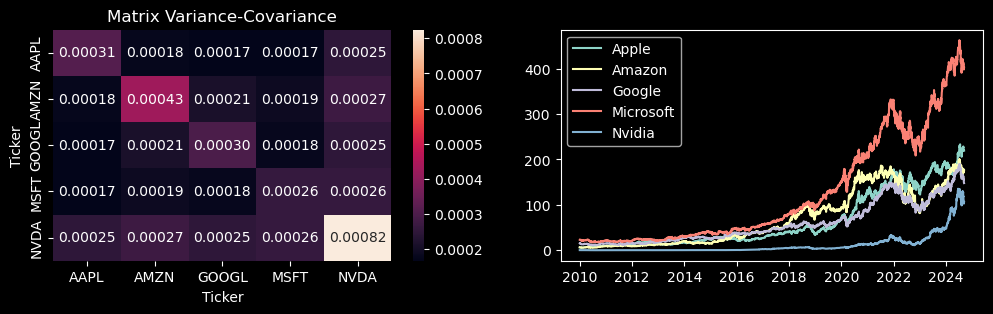

In [114]:
#Covariance Matrix to preserve the correlation betweens each asset individually:
cov_matrix = returns.cov()

figs, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

#Covariance Matrix:
sns.heatmap(data=cov_matrix, annot=True, ax=ax0, cbar=True, fmt='.5f')
ax0.set_title("Matrix Variance-Covariance")

#Stocks:
ax1.plot(stock_data.index, stock_data["AAPL"], label="Apple")
ax1.plot(stock_data.index, stock_data["AMZN"], label="Amazon")
ax1.plot(stock_data.index, stock_data["GOOGL"], label="Google")
ax1.plot(stock_data.index, stock_data["MSFT"], label="Microsoft")
ax1.plot(stock_data.index, stock_data["NVDA"], label="Nvidia")

#Legend:
ax1.legend()

1️⃣ **Simple context**

- Imagine you have a portfolio with multiple stocks: NVDA, AMZN, AAPL…
- Each stock has an expected average return (e.g., NVDA ~0.1% per day)
- Each stock fluctuates up and down over time
- Some stocks tend to move together (if NVDA goes up, AMZN often goes up too)
- We want to simulate what could happen to these stock returns over 1 year (252 trading days).

2️⃣ **Step by step**
Step 1: Use averages and relationships :
- mean_returns → the average historical returns of each stock
- cov_matrix → the relationships between stocks, showing how much they move together (correlation)

Step 2: Generate random returns :
- np.random.multivariate_normal creates random scenarios:
- Each stock gets a simulated daily return
- The returns are random, but follow the historical average and correlation with other stocks

Step 3: Repeat for multiple days :
- T = 252 → simulate 252 days (1 trading year)
- At the end, you get a matrix of simulated returns:
- Rows → each day
- Columns → each stock
- Each column shows how that stock might behave over the year, taking into account how it usually moves with other stocks.

Step 4: The result :
- correlated_random_returns → one possible year of simulated returns for your portfolio
- Each simulation is different, because it includes some randomness, but still respects historical volatility and correlations

In [380]:
#Return's (relative variation) and remove first line
returns = stock_data.pct_change().dropna()
#Mean return's
mean_returns = returns.mean()
#Covariance Matrix
cov_matrix = returns.cov()
#Random Weight's Investisment
weights = np.random.random(len(returns.columns))
weights /=np.sum(weights)
returns["portfolio"] = returns @ weights

#Mean return matrix (252 trading days in one year)
T=252 #time in days
M=100 # number of simulations

mean_returns_matrix = np.full(shape=(T, len(weights)), fill_value=mean_returns).T
portfolio_simulations = np.zeros(shape=(T,M))
#randomness
for i in range(M):
    # Générer T rendements corrélés pour tous les actifs
    correlated_random_returns = np.random.multivariate_normal(mean_returns, cov_matrix, T)
    
    # Calculer le rendement du portefeuille (pondéré)
    portfolio_simulations[:, i] = np.cumprod(np.inner(weights, correlated_random_returns)+1)*100

Text(0.5, 1.0, 'Histogram for the last day ($T$=252 days)')

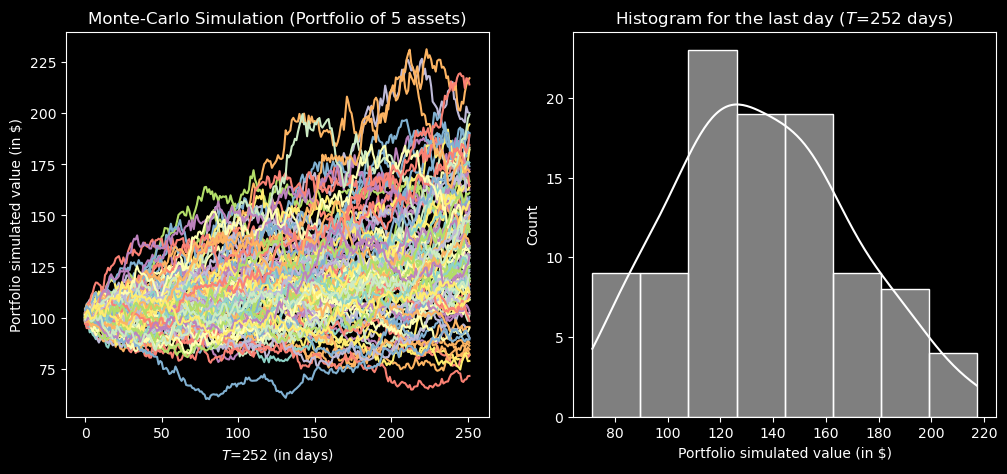

In [420]:
figs, (ax0,ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

ax0.plot(portfolio_simulations)
ax0.set_xlabel("$T$=252 (in days)")
ax0.set_ylabel("Portfolio simulated value (in $)")
ax0.set_title("Monte-Carlo Simulation (Portfolio of 5 assets)")

sns.histplot(portfolio_simulations[-1], ax=ax1, kde=True, color='white')
ax1.set_xlabel("Portfolio simulated value (in $)")
ax1.set_title("Histogram for the last day ($T$=252 days)")

### Cholesky Decomposition 
---
Cholesky decomposition is a mathematical tool that allows us to generate correlated random variables. Given a covariance matrix 
$Σ$ describing how assets move together, Cholesky finds a lower triangular matrix $L$ such that $Σ=LL⊤$. In simulations, we first generate independent standard normal random variables $Z$, then transform them as $X=LZ$. This produces new variables $X$ that retain the correct correlations and variances of the original assets. In finance, it is commonly used in Monte Carlo simulations to model realistic joint movements of multiple assets in a portfolio.


$$\Sigma =
\begin{pmatrix}
\sigma_1^2 & \text{Cov}(X_1, X_2) & \dots & \text{Cov}(X_1, X_n) \\
\text{Cov}(X_2, X_1) & \sigma_2^2 & \dots & \text{Cov}(X_2, X_n) \\
\vdots & \vdots & \ddots & \vdots \\
\text{Cov}(X_n, X_1) & \dots & \dots & \sigma_n^2
\end{pmatrix}
= L L^\top$$



In [447]:
#Variance-Covariance Matrix (Sigma)
Sigma = returns.cov()
print(Sigma)

Ticker         AAPL      AMZN     GOOGL      MSFT      NVDA  portfolio
Ticker                                                                
AAPL       0.000312  0.000175  0.000168  0.000168  0.000247   0.000243
AMZN       0.000175  0.000427  0.000212  0.000190  0.000274   0.000276
GOOGL      0.000168  0.000212  0.000296  0.000178  0.000247   0.000203
MSFT       0.000168  0.000190  0.000178  0.000261  0.000261   0.000205
NVDA       0.000247  0.000274  0.000247  0.000261  0.000824   0.000404
portfolio  0.000243  0.000276  0.000203  0.000205  0.000404   0.000291


In [457]:
L = cholesky_decomposition
print(L)

[[0.01765432 0.         0.         0.         0.        ]
 [0.00992739 0.01813373 0.         0.         0.        ]
 [0.00948936 0.00651579 0.01280555 0.         0.        ]
 [0.00953152 0.00526059 0.00415289 0.01121225 0.        ]
 [0.01399429 0.00743144 0.00517037 0.00598322 0.02259742]]


In [463]:
L_T = cholesky_decomposition.transpose()
print(L_T)

[[0.01765432 0.00992739 0.00948936 0.00953152 0.01399429]
 [0.         0.01813373 0.00651579 0.00526059 0.00743144]
 [0.         0.         0.01280555 0.00415289 0.00517037]
 [0.         0.         0.         0.01121225 0.00598322]
 [0.         0.         0.         0.         0.02259742]]


In [469]:
Sigma_LL_T = cholesky_decomposition @ cholesky_decomposition.transpose()
print(Sigma_LL_T)

[[0.00031168 0.00017526 0.00016753 0.00016827 0.00024706]
 [0.00017526 0.00042739 0.00021236 0.00019002 0.00027369]
 [0.00016753 0.00021236 0.00029649 0.0001779  0.00024743]
 [0.00016827 0.00019002 0.0001779  0.00026148 0.00026104]
 [0.00024706 0.00027369 0.00024743 0.00026104 0.00082424]]


Variance-Covariance Matrix of asset's returns
$$
\Sigma =
\begin{pmatrix}
0.00031168 & 0.00017526 & 0.00016753 & 0.00016827 & 0.00024706 \\
0.00017526 & 0.00042739 & 0.00021236 & 0.00019002 & 0.00027369 \\
0.00016753 & 0.00021236 & 0.00029649 & 0.00017790 & 0.00024743 \\
0.00016827 & 0.00019002 & 0.00017790 & 0.00026148 & 0.00026104 \\
0.00024706 & 0.00027369 & 0.00024743 & 0.00026104 & 0.00082424
\end{pmatrix}
$$


Each element of $(Z)$ represents an independent random shock for a given asset on a given day.
$$
Z =
\begin{pmatrix}
-0.1495 & -1.4600 & 0.6145 & -1.9944 & 0.6377 \\
0.2560 & -0.4390 & -0.8350 & 0.1637 & -0.2568 \\
-0.3498 & 0.9824 & -1.0067 & 1.6772 & -0.6836 \\
\vdots & \vdots & \vdots & \vdots & \vdots \\
0.3127 & -1.4044 & 2.1731 & -1.6339 & -0.7734 \\
-1.1425 & -0.5452 & -0.4925 & -1.1020 & -1.5957 \\
-1.4839 & -1.7356 & 2.3850 & -1.1789 & -1.0799
\end{pmatrix}$$

Mean returns matrix
$$
MRM =
\begin{pmatrix}
0.00111275 & 0.00111275 & 0.00111275 & \dots & 0.00111275 \\
0.00109746 & 0.00109746 & 0.00109746 & \dots & 0.00109746 \\
0.00075747 & 0.00075747 & 0.00075747 & \dots & 0.00075747 \\
0.00090392 & 0.00090392 & 0.00090392 & \dots & 0.00090392 \\
0.00190502 & 0.00190502 & 0.00190502 & \dots & 0.00190502
\end{pmatrix}
$$


Mathematically, we apply:

$$
R = \mu + LZ
$$

where:

* $(\mu)$ = `mean_returns_matrix`
  → the mean returns replicated over time

* $(Z)$ = independent random shocks

$$
Z \sim \mathcal{N}(0, I)
$$

* $(L)$ = `cholesky_decomposition`
  → encodes the volatilities and correlations between assets

* $(R)$ = `correlated_random_returns`
  → the final simulated asset returns


In [512]:
for i in range( M):
    # Randomess Matrix's shape: (252,5)
    Z = np.random.normal(size=(T, len(weights)))
    #Cholesky Decomposition:
    cholesky_decomposition = np.linalg.cholesky(cov_matrix)
    correlated_random_returns = mean_returns_matrix + np.inner(cholesky_decomposition,Z)
    # Calculer le rendement du portefeuille (pondéré)
    portfolio_simulations[:, i] = np.cumprod(np.inner(weights, correlated_random_returns.T)+1)*100

We generate random portfolio trajectories by taking the historical mean returns as a baseline and then adding independent random shocks. These shocks are transformed through the Cholesky decomposition so that the simulated returns reflect the real-world volatility and correlation structure between assets.

Text(0.5, 1.0, 'Histogram for the last day ($T$=252 days)')

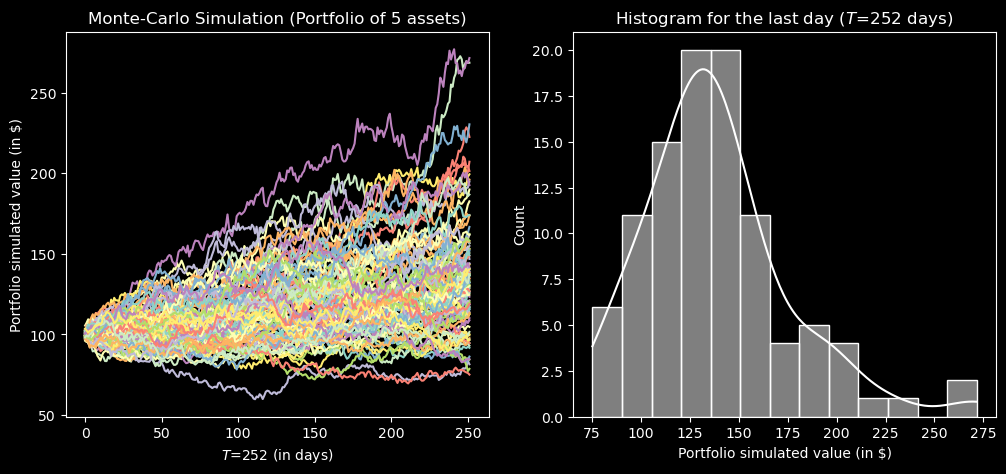

In [514]:
figs, (ax0,ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

ax0.plot(portfolio_simulations)
ax0.set_xlabel("$T$=252 (in days)")
ax0.set_ylabel("Portfolio simulated value (in $)")
ax0.set_title("Monte-Carlo Simulation (Portfolio of 5 assets)")

sns.histplot(portfolio_simulations[-1], ax=ax1, kde=True, color='white')
ax1.set_xlabel("Portfolio simulated value (in $)")
ax1.set_title("Histogram for the last day ($T$=252 days)")